In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import rebound as reb
import seaborn as sns

sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

In [3]:
def zero_to_2pi(x):
    x = x % 2*pi
    if x < 0:
        return x + 2*pi
    else:
        return x
def mpi_to_pi(x):
    x = x%2*pi
    if x > pi:
        return x - 2*pi
    elif x < -pi:
        return x + 2*pi
    else:
        return x    

Set up the TRAPPIST-1 parameters

In [4]:
mtrapa = 0.0802
mearth = 0.000003003
days = 1.0/365.25
deg = pi/180.0
epoch = 7400.0

Here we take the convention that the $x$-axis points toward Earth, and ensure that the mid-transit times match the fitted values by adjusting the mean anomaly appropriately.  We choose the orientation of the orbit uniformly at random, and choose small eccentricities and inclinations (consistent with observations).

In [5]:
def add_trappista(sim):
    sim.add(m=mtrapa)
def add_trappistp(sim, P0, dP0, T0, dT0, M0, dM0):
    e = abs(0.04*randn())
    i = 0.5*deg*randn()
    omega = 2*pi*rand()
    Omega = 2*pi*rand()
    
    P = abs(P0 + dP0*randn())
    T = abs(T0 + dT0*randn())
    M = abs(M0 + dM0*randn())
    
    pomega = omega + Omega 
    
    M_at_trans = - pomega
    dM = (T-epoch)/P*2*pi
    
    M_at_epoch = M_at_trans - dM
    
    a = cbrt(sim.G*mtrapa*P*P*days*days/(4.0*pi*pi))
    
    sim.add(m=M*mearth, a=a, M=M_at_epoch, omega=omega, Omega=Omega, e=e, inc=i)

---------------------------------
REBOUND version:     	3.2.2
REBOUND built on:    	Feb 22 2017 20:56:24
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	0.000000
Current timestep:    	0.000217
---------------------------------
<rebound.Particle object, m=0.0802 x=3.8637264680189945e-06 y=-1.1808607813047363e-06 z=2.0126154225328307e-08 vx=0.001072919954794244 vy=0.0013435940641517892 vz=-2.3768625234447535e-06>
<rebound.Particle object, m=1.5466862861193232e-06 x=-0.0031283410597834032 y=0.011087105331603399 z=6.364539117642395e-05 vx=-15.790865954118905 vy=-3.906119068361207 vz=0.06505358551169871>
<rebound.Particle object, m=3.806277333634497e-06 x=-0.012000391183283615 y=0.010194606567109167 z=-9.54337426013196e-06 vx=-8.934205591970578 vy=-10.685980081523828 vz=-0.0597066043791896>
<rebound.Particle object, m=3.760401523763913e-07 x=-0.004450088225646166 y=0.021446378116980656 z=0.0002538678818714769 vx=-11.554874462755832 vy=-2.808743464678408 vz=-0.0868

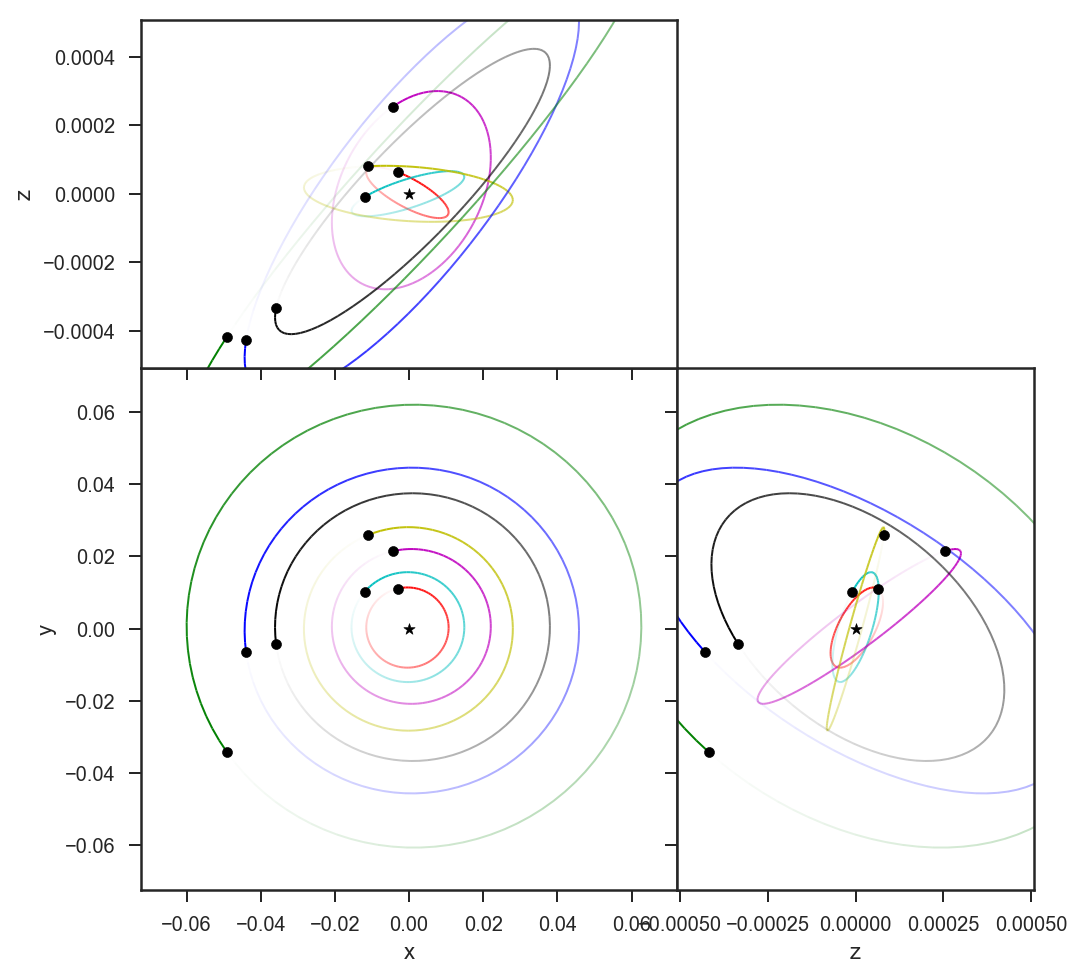

In [15]:
sim = reb.Simulation()
sim.G = 4.0*pi*pi
sim.exit_max_distance = 100 # Raise an exception if any body goes beyond 100 AU.
sim.integrator = "whfast" # Hermes uses the Wisdom-Holman scheme with close encounters integrated by IAS15
sim.ri_whfast.safe_mode = 0 # This and the next setting are much faster, but only OK if you don't access the particle array between steps
sim.ri_whfast.corrector = 11 # Same
sim.dt = 0.05*pi/3.0*1.51087081*days # Close to 5% of inner orbit period, but not commensurate

add_trappista(sim)
add_trappistp(sim, 1.51087081, 0.6e-6, 7322.51736, 0.00010, 0.85, 0.72)
add_trappistp(sim, 2.4218233, 0.17e-5, 7282.80728, 0.00019, 1.38, 0.61)
add_trappistp(sim, 4.049610, 0.63e-4, 7670.14165, 0.00035, 0.41, 0.27)
add_trappistp(sim, 6.099615, 0.11e-4, 7660.37859, 0.00038, 0.62, 0.58)
add_trappistp(sim, 9.206690, 0.15e-4, 7671.39767, 0.00023, 0.68, 0.18)
add_trappistp(sim, 12.35294, 0.12e-3, 7665.34937, 0.00021, 0.94, 0.63)
add_trappistp(sim, 20.0, 6.0, 7662.55463, 0.00056, 0.755**3, 3.0*0.755**2*0.034)

sim.move_to_com()
E0 = sim.calculate_energy()

reb.OrbitPlot(sim, color=True, slices=True)

sim.status()

In [6]:
def zero_to_2pi(x):
    x = x % 2*pi
    if x < 0:
        return x + 2*pi
    else:
        return x
def mpi_to_pi(x):
    x = x%2*pi
    if x > pi:
        return x - 2*pi
    elif x < -pi:
        return x + 2*pi
    else:
        return x    

In [17]:
sim.initSimulationArchive("archive.bin", interval=100)
sim.estimateSimulationArchiveSize(1000000)

4640000

Now we integrate the system, saving the orbital elements in our archive every ~100 years, up to 10k years (the system seems to be unstable, so no point in doing longer simulation until we find some conditions that are stable enough for this short one).

In [18]:
sim.integrate(10000, exact_finish_time=0)

Execute this cell if you want to continue the integration to 1M years:

In [34]:
sim.integrate(1000000, exact_finish_time=0)

Escape: A particle escaped (r>exit_max_distance).

In [7]:
sa = reb.SimulationArchive("archive.bin")
sim = sa[-1]
print("Maximum time achieved = {:g}".format(sim.t))

Maximum time achieved = 511500


Energy error = 0.0131604


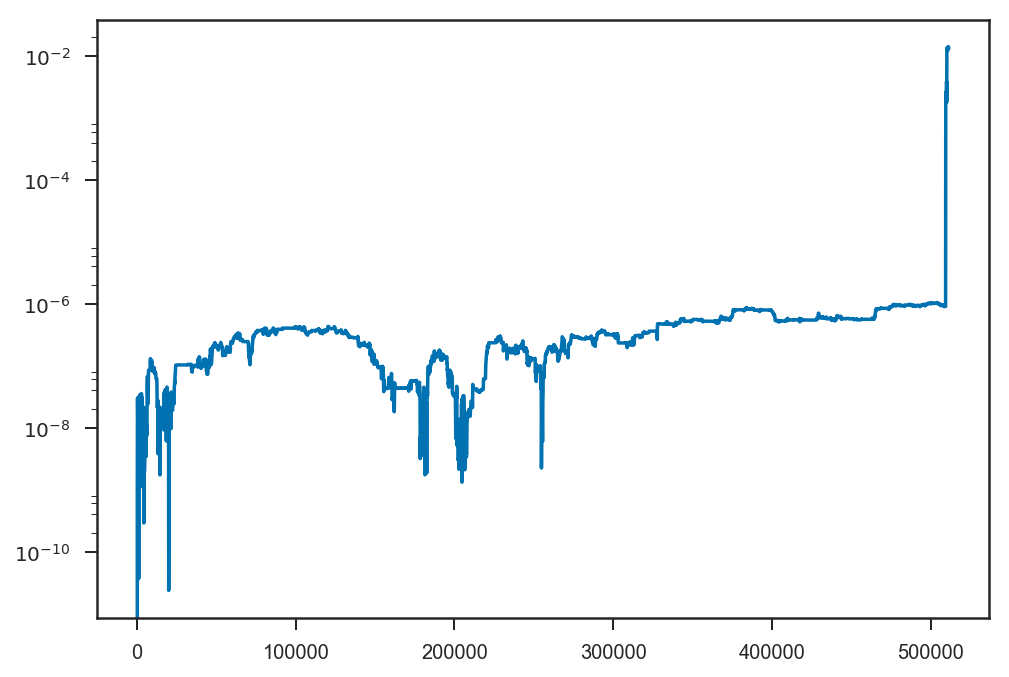

In [12]:
E0 = sa[0].calculate_energy()
es = array([s.calculate_energy() for s in sa])
ts = array([s.t for s in sa])
plot(ts, abs((es-E0)/E0))
yscale("log")
print("Energy error = {:g}".format(abs(1.0-sim.calculate_energy()/E0)))

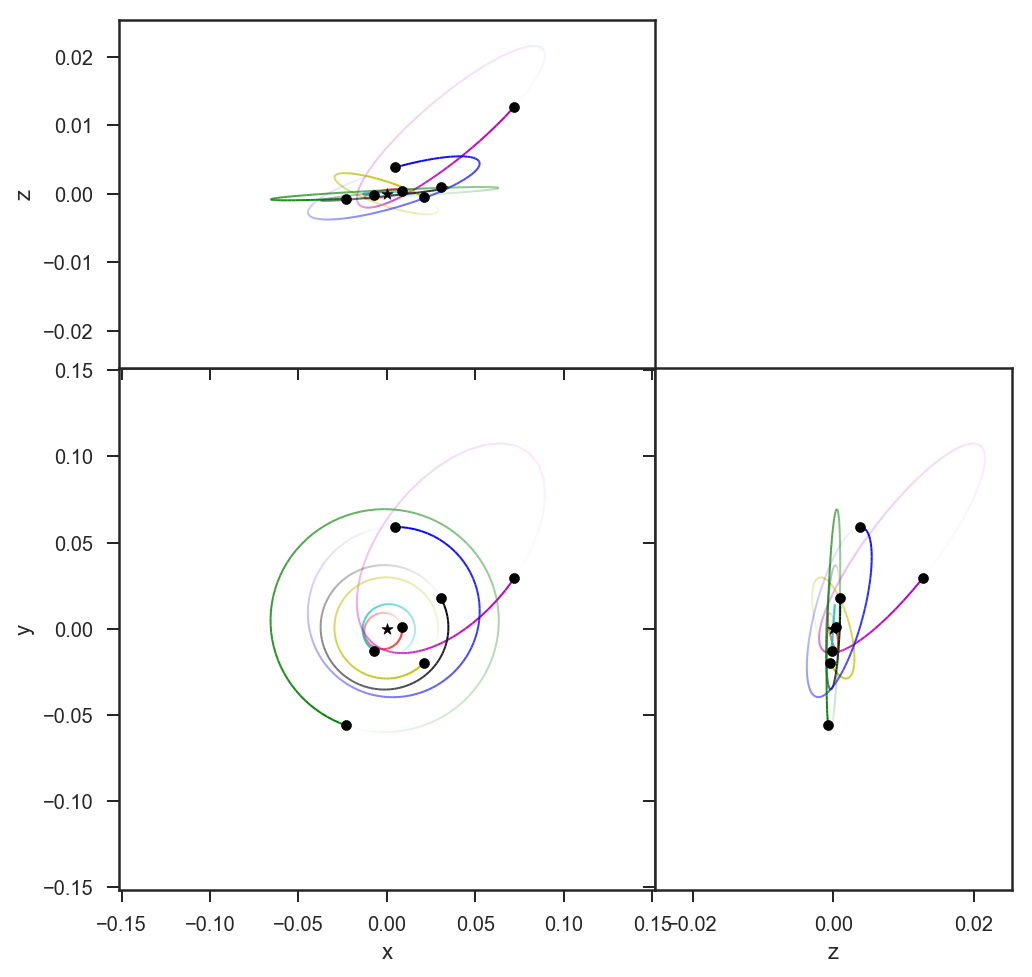

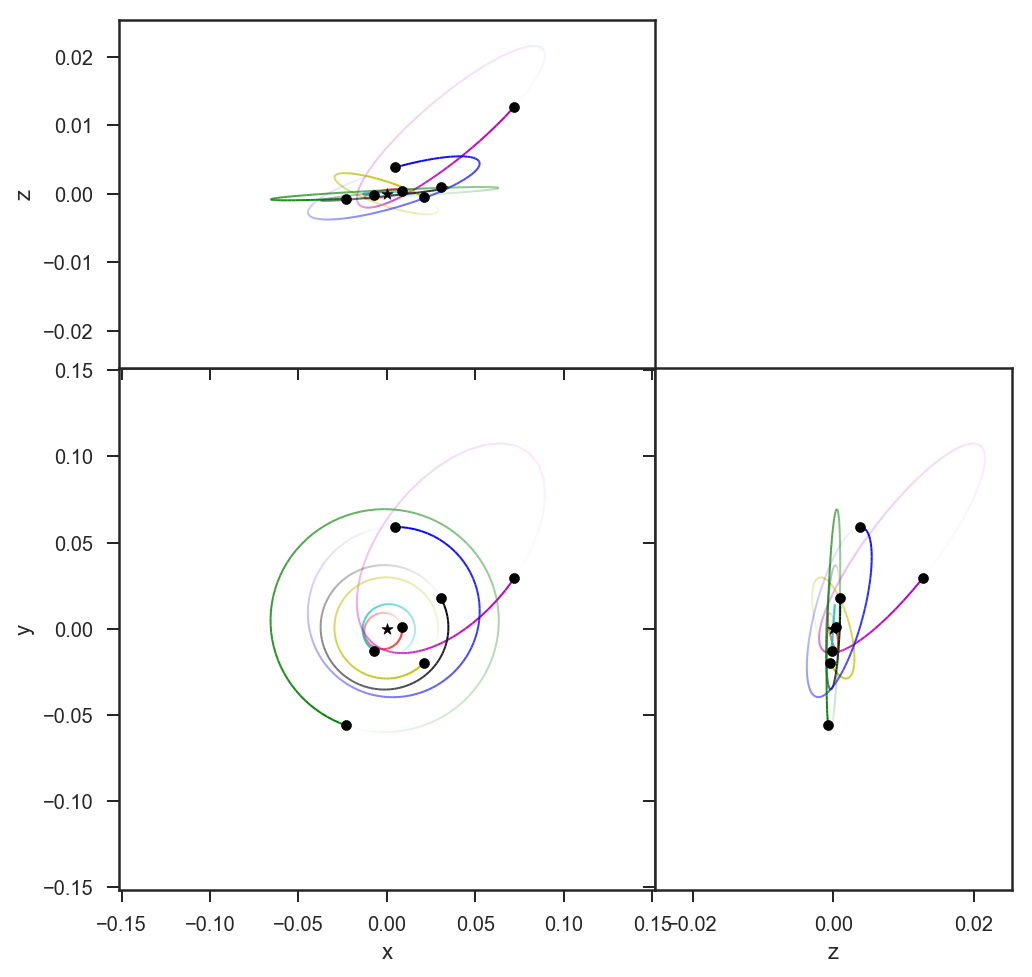

In [13]:
reb.OrbitPlot(sim, color=True, slices=True)

In [14]:
def resonant_arguments(pi, ni, pj, nj, sa):
    assert ni < nj
    assert pi < pj
    
    ne = nj - ni
    
    inner = array([mpi_to_pi(ni*s.particles[pi].l - nj*s.particles[pj].l + ne*s.particles[pi].pomega) for s in sa])
    outer = array([mpi_to_pi(ni*s.particles[pi].l - nj*s.particles[pj].l + ne*s.particles[pj].pomega) for s in sa])
    
    return (inner, outer)

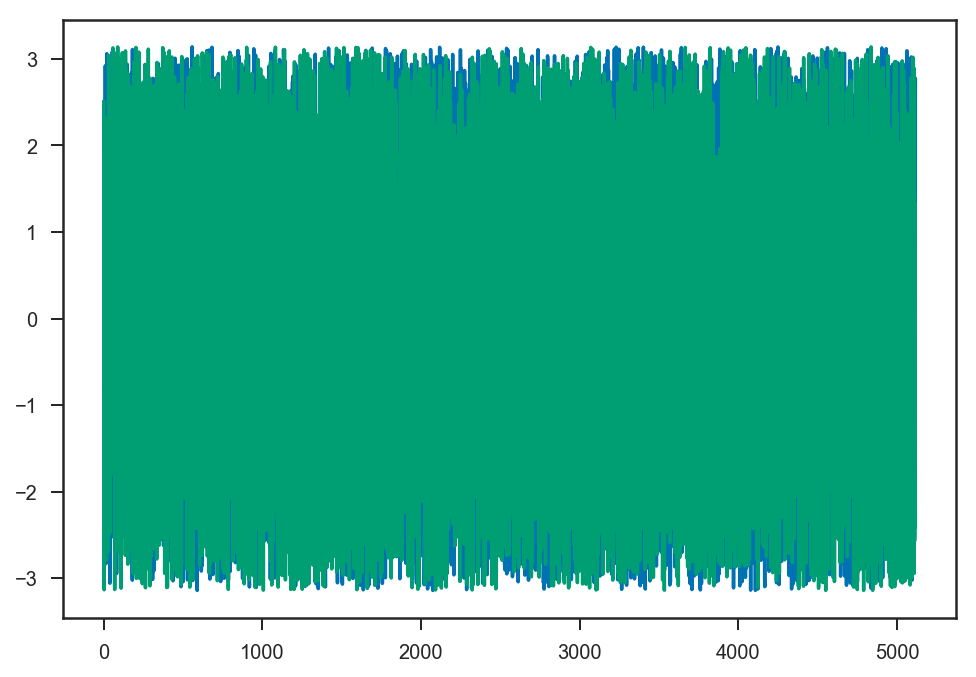

In [15]:
inner, outer = resonant_arguments(1, 5, 2, 8, sa)
plot(inner)
plot(outer)